In [ ]:
!pip install progressbar2

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from torch import nn
from collections import OrderedDict
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
import torchvision
import random
from torch.utils.data import Subset
from matplotlib import pyplot as plt
from torchsummary import summary
from torchvision import transforms
import progressbar as pb
import numpy as np

SUM = lambda x,y : x+y

def check_equity(property,a,b):
    pa = getattr(a,property)
    pb = getattr(b,property)
    assert  pa==pb, "Different {}: {}!={}".format(property,pa,pb)

    return pa

def module_unwrap(mod:nn.Module,recursive=False):
    children = OrderedDict()
    try:
        for name, module in mod.named_children():
            if (recursive):
                recursive_call = module_unwrap(module,recursive=True)
                if (len(recursive_call)>0):
                    for k,v in recursive_call.items():
                        children[name+"_"+k] = v
                else:
                    children[name] = module
            else:
                children[name] = module
    except AttributeError:
        pass

    return children

class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels,batch_norm=False):

        super().__init__()

        conv2_params = {'kernel_size': (3, 3),
                        'stride'     : (1, 1),
                        'padding'   : 1
                        }

        noop = lambda x : x

        self._batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels , **conv2_params)
        #self.bn1 = nn.BatchNorm2d(out_channels) if batch_norm else noop
        self.bn1 = nn.GroupNorm(16, out_channels) if batch_norm else noop

        self.conv2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels, **conv2_params)
        #self.bn2 = nn.BatchNorm2d(out_channels) if batch_norm else noop
        self.bn2 = nn.GroupNorm(16, out_channels) if batch_norm else noop

        self.max_pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    @property
    def batch_norm(self):
        return self._batch_norm

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.max_pooling(x)

        return x

class Classifier(nn.Module):

    def __init__(self,num_classes=1):
        super().__init__()

        self.classifier = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 512),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self,x):

        return self.classifier(x)

class VGG16(nn.Module):

  def __init__(self, input_size, batch_norm=False):
    super(VGG16, self).__init__()

    self.in_channels,self.in_width,self.in_height = input_size

    self.block_1 = VGGBlock(self.in_channels,64,batch_norm=batch_norm)
    self.block_2 = VGGBlock(64, 128,batch_norm=batch_norm)
    self.block_3 = VGGBlock(128, 256,batch_norm=batch_norm)
    self.block_4 = VGGBlock(256,512,batch_norm=batch_norm)


  @property
  def input_size(self):
      return self.in_channels,self.in_width,self.in_height

  def forward(self, x):

    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.block_4(x)
    # x = self.avgpool(x)
    x = torch.flatten(x,1)

    return x

class CombinedLoss(nn.Module):
    def __init__(self, loss_a, loss_b, loss_combo, _lambda=1.0):
        super().__init__()
        self.loss_a = loss_a
        self.loss_b = loss_b
        self.loss_combo = loss_combo

        self.register_buffer('_lambda',torch.tensor(float(_lambda),dtype=torch.float32))


    def forward(self,y_hat,y):

        return self.loss_a(y_hat[0],y[0]) + self.loss_b(y_hat[1],y[1]) + self._lambda * self.loss_combo(y_hat[2],torch.cat(y,0))

DO='TRAIN'

random.seed(47)

combo_fn = SUM

lambda_reg = 1

In [ ]:
def test(net,classifier, loader):

      net.to(dev)
      classifier.to(dev)

      net.eval()

      sum_accuracy = 0

      # Process each batch
      for j, (input, labels) in enumerate(loader):

        input = input.to(dev)
        labels = labels.float().to(dev)

        features = net(input)

        pred = torch.squeeze(classifier(features))

        # https://discuss.pytorch.org/t/bcewithlogitsloss-and-model-accuracy-calculation/59293/ 2
        pred_labels = (pred >= 0.0).long()  # Binarize predictions to 0 and 1

        batch_accuracy = (pred_labels == labels).sum().item() / len(labels)

        # Update accuracy
        sum_accuracy += batch_accuracy

      epoch_accuracy = sum_accuracy / len(loader)
    
      return epoch_accuracy

      #print(f"Accuracy: {epoch_accuracy:0.5}")

In [ ]:
def train(nets, loaders, optimizer, criterion, epochs=20, dev=None, save_param=False, model_name="valerio"):
    # try:
      nets = [n.to(dev) for n in nets]

      model_a = module_unwrap(nets[0], True)
      model_b = module_unwrap(nets[1], True)
      model_c = module_unwrap(nets[2], True)

      reg_loss = nn.MSELoss()

      criterion.to(dev)
      reg_loss.to(dev)

      # Initialize history
      history_loss = {"train": [], "val": [], "test": []}
      history_accuracy = {"train": [], "val": [], "test": []}
      history_test = []
      # Store the best val accuracy
      best_val_accuracy = 0

      # Process each epoch
      for epoch in range(epochs):
        # Initialize epoch variables
        sum_loss = {"train": 0, "val": 0, "test": 0}
        sum_accuracy = {"train": [0,0,0], "val": [0,0,0], "test": [0,0,0]}

        progbar = None
        # Process each split
        for split in ["train", "val", "test"]:
          if split == "train":
            for n in nets:
              n.train()
            widgets = [
              ' [', pb.Timer(), '] ',
              pb.Bar(),
              ' [', pb.ETA(), '] ', pb.Variable('ta','[Train Acc: {formatted_value}]')
            ]

            progbar = pb.ProgressBar(max_value=len(loaders[split][0]),widgets=widgets,redirect_stdout=True)

          else:
            for n in nets:
              n.eval()
          # Process each batch
          for j,((input_a, labels_a),(input_b, labels_b)) in enumerate(zip(loaders[split][0],loaders[split][1])):

            input_a = input_a.to(dev)
            input_b = input_b.to(dev)

            labels_a = labels_a.float().to(dev)
            labels_b = labels_b.float().to(dev)


            inputs = torch.cat([input_a,input_b],axis=0)
            labels = torch.cat([labels_a, labels_b])


            # Reset gradients
            optimizer.zero_grad()
            # Compute output
            features_a = nets[0](input_a)
            features_b = nets[1](input_b)
            features_c = nets[2](inputs)

            pred_a = torch.squeeze(nets[3](features_a))
            pred_b = torch.squeeze(nets[3](features_b))
            pred_c = torch.squeeze(nets[3](features_c))

            loss = criterion(pred_a, labels_a) + criterion(pred_b, labels_b) + criterion(pred_c, labels)

            for n in model_a:
              layer_a = model_a[n]
              layer_b = model_b[n]
              layer_c = model_c[n]
              if (isinstance(layer_a,nn.Conv2d)):
                loss += lambda_reg * reg_loss(combo_fn(layer_a.weight,layer_b.weight),layer_c.weight)
                if (layer_a.bias is not None):
                  loss += lambda_reg * reg_loss(combo_fn(layer_a.bias, layer_b.bias), layer_c.bias)

            # Update loss
            sum_loss[split] += loss.item()
            # Check parameter update
            if split == "train":
              # Compute gradients
              loss.backward()
              # Optimize
              optimizer.step()

            # Compute accuracy

            #https://discuss.pytorch.org/t/bcewithlogitsloss-and-model-accuracy-calculation/59293/ 2
            pred_labels_a = (pred_a >= 0.0).long()  # Binarize predictions to 0 and 1
            pred_labels_b = (pred_b >= 0.0).long()  # Binarize predictions to 0 and 1
            pred_labels_c = (pred_c >= 0.0).long()  # Binarize predictions to 0 and 1


            batch_accuracy_a = (pred_labels_a == labels_a).sum().item() / len(labels_a)
            batch_accuracy_b = (pred_labels_b == labels_b).sum().item() / len(labels_b)
            batch_accuracy_c = (pred_labels_c == labels).sum().item() / len(labels)

            # Update accuracy
            sum_accuracy[split][0] += batch_accuracy_a
            sum_accuracy[split][1] += batch_accuracy_b
            sum_accuracy[split][2] += batch_accuracy_c


            if (split=='train'):
              progbar.update(j, ta=batch_accuracy_c)

        if (progbar is not None):
          progbar.finish()
        # Compute epoch loss/accuracy
        epoch_loss = {split: sum_loss[split] / len(loaders[split][0]) for split in ["train", "val", "test"]}
        epoch_accuracy = {split: [sum_accuracy[split][i] / len(loaders[split][0]) for i in range(len(sum_accuracy[split])) ] for split in ["train", "val", "test"]}

        # # Store params at the best validation accuracy
        # if save_param and epoch_accuracy["val"] > best_val_accuracy:
        #   # torch.save(net.state_dict(), f"{net.__class__.__name__}_best_val.pth")
        #   torch.save(net.state_dict(), f"{model_name}_best_val.pth")
        #   best_val_accuracy = epoch_accuracy["val"]

        print(f"Epoch {epoch + 1}:")
        # Update history
        for split in ["train", "val", "test"]:
          history_loss[split].append(epoch_loss[split])
          history_accuracy[split].append(epoch_accuracy[split])
          # Print info
          print(f"\t{split}\tLoss: {epoch_loss[split]:0.5}\tVGG 1:{epoch_accuracy[split][0]:0.5}"
                f"\tVGG 2:{epoch_accuracy[split][1]:0.5}\tVGG *:{epoch_accuracy[split][2]:0.5}")

        if save_param:
          torch.save({'vgg_a':nets[0].state_dict(),'vgg_b':nets[1].state_dict(),'vgg_star':nets[2].state_dict(),'classifier':nets[3].state_dict()},f'{model_name}.pth')
        
        print(f"Accuracy test VGGA: {test(nets[0], nets[3], test_loader_all):0.5}")
        print(f"Accuracy test VGGB: {test(nets[1], nets[3], test_loader_all):0.5}")
        print(f"Accuracy test VGG*: {test(nets[2], nets[3], test_loader_all):0.5}")
 
        summed_state_dict = OrderedDict()
 
        for key in nets[2].state_dict():
          if key.find('conv') >=0:
            #print(key)
            summed_state_dict[key] = combo_fn(nets[0].state_dict()[key],nets[1].state_dict()[key])
          else:
            summed_state_dict[key] = nets[2].state_dict()[key]
 
        nets[2].load_state_dict(summed_state_dict)
        accuracy_star = test(nets[2], nets[3], test_loader_all)
        print(f"Accuracy test VGGSTAR: {accuracy_star:0.5}")
        history_test.append(accuracy_star)


      # Plot accuracy
      plt.title("Accuracy VGGSTAR over epochs")
      plt.plot(history_test)
      #plt.legend()
      plt.show()  

In [ ]:
def parse_dataset(dataset):

  dataset.targets = dataset.targets % 2

  return dataset

root_dir = './'

rescale_data = transforms.Lambda(lambda x : x/255)

# Compose transformations
data_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  rescale_data,
  #transforms.Normalize((-0.7376), (0.5795))
])

test_transform = transforms.Compose([
  transforms.Resize(32),
  transforms.ToTensor(),
  rescale_data,
  #transforms.Normalize((0.1327), (0.2919))
])

# Load MNIST dataset with transforms
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, download=True, transform=data_transform)
test_set = torchvision.datasets.MNIST(root=root_dir, train=False, download=True, transform=test_transform)

train_set = parse_dataset(train_set)
test_set = parse_dataset(test_set)

train_idx = np.random.permutation(np.arange(len(train_set)))
test_idx = np.arange(len(test_set))

val_frac = 0.1

n_val = int(len(train_idx) * val_frac)
val_idx = train_idx[0:n_val]
train_idx = train_idx[n_val:]

h = len(train_idx)//2

train_set_a = Subset(train_set,train_idx[0:h])
train_set_b = Subset(train_set,train_idx[h:])

h = len(val_idx)//2

val_set_a = Subset(train_set,val_idx[0:h])
val_set_b = Subset(train_set,val_idx[h:])

h = len(test_idx)//2

test_set_a = Subset(test_set,test_idx[0:h])
test_set_b = Subset(test_set,test_idx[h:])

# Define loaders

train_loader_a = DataLoader(train_set_a, batch_size=128, num_workers=0, shuffle=True, drop_last=True)
val_loader_a   = DataLoader(val_set_a,   batch_size=128, num_workers=0, shuffle=False, drop_last=False)
test_loader_a  = DataLoader(test_set_a,  batch_size=128, num_workers=0, shuffle=False, drop_last=False)

train_loader_b = DataLoader(train_set_b, batch_size=128, num_workers=0, shuffle=True, drop_last=True)
val_loader_b   = DataLoader(val_set_b,   batch_size=128, num_workers=0, shuffle=False, drop_last=False)
test_loader_b  = DataLoader(test_set_b,  batch_size=128, num_workers=0, shuffle=False, drop_last=False)

test_loader_all = DataLoader(test_set,batch_size=128, num_workers=0,shuffle=False,drop_last=False)


# Define dictionary of loaders
loaders = {"train": [train_loader_a,train_loader_b],
           "val":   [val_loader_a,val_loader_b],
           "test":  [test_loader_a,test_loader_b]}


0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
model1 = VGG16((1,32,32),batch_norm=True)
model2 = VGG16((1,32,32),batch_norm=True)
model3 = VGG16((1,32,32),batch_norm=True)
classifier = Classifier(num_classes=1)

nets = [model1,model2,model3,classifier]

dev = torch.device('cuda')

parameters = set()

for n in nets:
  parameters |= set(n.parameters())

optimizer = torch.optim.SGD(parameters, lr = 0.01)
# Define a loss
criterion = nn.BCEWithLogitsLoss()#,nn.BCEWithLogitsLoss(),nn.BCEWithLogitsLoss(),_lambda = 1)
n_params = 0

 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.539]


Epoch 1:
	train	Loss: 2.3142	VGG 1:0.50175	VGG 2:0.50089	VGG *:0.50309
	val	Loss: 2.2843	VGG 1:0.50037	VGG 2:0.52358	VGG *:0.51197
	test	Loss: 2.2855	VGG 1:0.50859	VGG 2:0.50293	VGG *:0.50576
Accuracy test VGGA: 0.50732
Accuracy test VGGB: 0.50732
Accuracy test VGG*: 0.50732
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.527]


Epoch 2:
	train	Loss: 2.0821	VGG 1:0.50629	VGG 2:0.5064	VGG *:0.50339
	val	Loss: 2.0792	VGG 1:0.50037	VGG 2:0.52358	VGG *:0.51197
	test	Loss: 2.0804	VGG 1:0.50859	VGG 2:0.50293	VGG *:0.50576
Accuracy test VGGA: 0.50732
Accuracy test VGGB: 0.50732
Accuracy test VGG*: 0.50732
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.492]


Epoch 3:
	train	Loss: 2.0813	VGG 1:0.50487	VGG 2:0.50737	VGG *:0.50192
	val	Loss: 2.0788	VGG 1:0.50037	VGG 2:0.52358	VGG *:0.51197
	test	Loss: 2.0797	VGG 1:0.50859	VGG 2:0.50293	VGG *:0.50576
Accuracy test VGGA: 0.50732
Accuracy test VGGB: 0.50732
Accuracy test VGG*: 0.50732
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.465]


Epoch 4:
	train	Loss: 2.0806	VGG 1:0.50714	VGG 2:0.50342	VGG *:0.50255
	val	Loss: 2.0778	VGG 1:0.49963	VGG 2:0.52358	VGG *:0.51197
	test	Loss: 2.0791	VGG 1:0.49141	VGG 2:0.50293	VGG *:0.50576
Accuracy test VGGA: 0.49268
Accuracy test VGGB: 0.50732
Accuracy test VGG*: 0.50732
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.531]


Epoch 5:
	train	Loss: 2.0795	VGG 1:0.51436	VGG 2:0.50461	VGG *:0.50277
	val	Loss: 2.0774	VGG 1:0.50037	VGG 2:0.52358	VGG *:0.51197
	test	Loss: 2.078	VGG 1:0.50859	VGG 2:0.50293	VGG *:0.50576
Accuracy test VGGA: 0.50732
Accuracy test VGGB: 0.50732
Accuracy test VGG*: 0.50732
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.469]


Epoch 6:
	train	Loss: 2.0799	VGG 1:0.51358	VGG 2:0.50205	VGG *:0.50305
	val	Loss: 2.0773	VGG 1:0.50037	VGG 2:0.52358	VGG *:0.51197
	test	Loss: 2.0784	VGG 1:0.50859	VGG 2:0.50293	VGG *:0.50576
Accuracy test VGGA: 0.50732
Accuracy test VGGB: 0.50732
Accuracy test VGG*: 0.50732
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.535]


Epoch 7:
	train	Loss: 2.078	VGG 1:0.52906	VGG 2:0.49781	VGG *:0.50484
	val	Loss: 2.0735	VGG 1:0.74702	VGG 2:0.52358	VGG *:0.51197
	test	Loss: 2.0742	VGG 1:0.74785	VGG 2:0.50293	VGG *:0.50576
Accuracy test VGGA: 0.7682
Accuracy test VGGB: 0.50732
Accuracy test VGG*: 0.50732
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.492]


Epoch 8:
	train	Loss: 2.0632	VGG 1:0.58326	VGG 2:0.50119	VGG *:0.50724
	val	Loss: 2.0437	VGG 1:0.71126	VGG 2:0.52358	VGG *:0.51197
	test	Loss: 2.045	VGG 1:0.69512	VGG 2:0.50293	VGG *:0.50576
Accuracy test VGGA: 0.72745
Accuracy test VGGB: 0.50732
Accuracy test VGG*: 0.50732
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.465]


Epoch 9:
	train	Loss: 2.0439	VGG 1:0.60763	VGG 2:0.50279	VGG *:0.50441
	val	Loss: 2.029	VGG 1:0.70712	VGG 2:0.52358	VGG *:0.51197
	test	Loss: 2.0316	VGG 1:0.68965	VGG 2:0.50293	VGG *:0.50576
Accuracy test VGGA: 0.71529
Accuracy test VGGB: 0.50732
Accuracy test VGG*: 0.50732
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.547]


Epoch 10:
	train	Loss: 1.8774	VGG 1:0.76298	VGG 2:0.50227	VGG *:0.52574
	val	Loss: 1.8533	VGG 1:0.77772	VGG 2:0.52358	VGG *:0.51751
	test	Loss: 1.8566	VGG 1:0.76621	VGG 2:0.50293	VGG *:0.5166
Accuracy test VGGA: 0.78946
Accuracy test VGGB: 0.50732
Accuracy test VGG*: 0.5175
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.695]


Epoch 11:
	train	Loss: 1.977	VGG 1:0.66034	VGG 2:0.51083	VGG *:0.57548
	val	Loss: 1.8678	VGG 1:0.66364	VGG 2:0.47642	VGG *:0.65034
	test	Loss: 1.8468	VGG 1:0.69102	VGG 2:0.49707	VGG *:0.66797
Accuracy test VGGA: 0.68888
Accuracy test VGGB: 0.49278
Accuracy test VGG*: 0.66624
Accuracy test VGGSTAR: 0.74258


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.777]


Epoch 12:
	train	Loss: 1.6952	VGG 1:0.78709	VGG 2:0.55026	VGG *:0.70214
	val	Loss: 1.5916	VGG 1:0.81036	VGG 2:0.52358	VGG *:0.78764
	test	Loss: 1.5727	VGG 1:0.80918	VGG 2:0.50293	VGG *:0.80527
Accuracy test VGGA: 0.82397
Accuracy test VGGB: 0.50732
Accuracy test VGG*: 0.80311
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:   0.82]


Epoch 13:
	train	Loss: 1.6357	VGG 1:0.84725	VGG 2:0.55904	VGG *:0.65234
	val	Loss: 1.4188	VGG 1:0.86988	VGG 2:0.47642	VGG *:0.80329
	test	Loss: 1.392	VGG 1:0.86621	VGG 2:0.49707	VGG *:0.82354
Accuracy test VGGA: 0.88074
Accuracy test VGGB: 0.49268
Accuracy test VGG*: 0.82071
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.785]


Epoch 14:
	train	Loss: 1.6942	VGG 1:0.78583	VGG 2:0.55186	VGG *:0.65443
	val	Loss: 1.32	VGG 1:0.91881	VGG 2:0.47642	VGG *:0.81871
	test	Loss: 1.3083	VGG 1:0.91348	VGG 2:0.49707	VGG *:0.82832
Accuracy test VGGA: 0.9282
Accuracy test VGGB: 0.49268
Accuracy test VGG*: 0.82783
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.875]


Epoch 15:
	train	Loss: 1.6065	VGG 1:0.81994	VGG 2:0.58333	VGG *:0.68346
	val	Loss: 1.0651	VGG 1:0.9262	VGG 2:0.7381	VGG *:0.85921
	test	Loss: 1.0259	VGG 1:0.91992	VGG 2:0.76465	VGG *:0.87754
Accuracy test VGGA: 0.93513
Accuracy test VGGB: 0.74644
Accuracy test VGG*: 0.87619
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.914]


Epoch 16:
	train	Loss: 1.2512	VGG 1:0.91194	VGG 2:0.72719	VGG *:0.74418
	val	Loss: 0.90931	VGG 1:0.93769	VGG 2:0.79622	VGG *:0.85642
	test	Loss: 0.84405	VGG 1:0.9332	VGG 2:0.82852	VGG *:0.87256
Accuracy test VGGA: 0.94531
Accuracy test VGGB: 0.80854
Accuracy test VGG*: 0.87114
Accuracy test VGGSTAR: 0.51108


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.918]


Epoch 17:
	train	Loss: 1.0719	VGG 1:0.94513	VGG 2:0.79196	VGG *:0.75571
	val	Loss: 0.84341	VGG 1:0.95168	VGG 2:0.75563	VGG *:0.91283
	test	Loss: 0.79568	VGG 1:0.94316	VGG 2:0.79316	VGG *:0.92627
Accuracy test VGGA: 0.95441
Accuracy test VGGB: 0.76731
Accuracy test VGG*: 0.92544
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.887]


Epoch 18:
	train	Loss: 0.94734	VGG 1:0.95491	VGG 2:0.8314	VGG *:0.77277
	val	Loss: 0.63637	VGG 1:0.96122	VGG 2:0.8663	VGG *:0.91185
	test	Loss: 0.53921	VGG 1:0.95547	VGG 2:0.90996	VGG *:0.92627
Accuracy test VGGA: 0.96123
Accuracy test VGGB: 0.8838
Accuracy test VGG*: 0.92623
Accuracy test VGGSTAR: 0.50761


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.848]


Epoch 19:
	train	Loss: 1.0194	VGG 1:0.96243	VGG 2:0.7824	VGG *:0.75939
	val	Loss: 0.71388	VGG 1:0.96763	VGG 2:0.8165	VGG *:0.90318
	test	Loss: 0.63542	VGG 1:0.96309	VGG 2:0.84668	VGG *:0.91807
Accuracy test VGGA: 0.97093
Accuracy test VGGB: 0.82397
Accuracy test VGG*: 0.91634
Accuracy test VGGSTAR: 0.57921


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.848]


Epoch 20:
	train	Loss: 0.83478	VGG 1:0.96603	VGG 2:0.87723	VGG *:0.77195
	val	Loss: 0.68753	VGG 1:0.96675	VGG 2:0.92462	VGG *:0.83359
	test	Loss: 0.60063	VGG 1:0.96133	VGG 2:0.95215	VGG *:0.8459
Accuracy test VGGA: 0.97132
Accuracy test VGGB: 0.93602
Accuracy test VGG*: 0.84484
Accuracy test VGGSTAR: 0.63489


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.945]


Epoch 21:
	train	Loss: 0.79184	VGG 1:0.97121	VGG 2:0.87589	VGG *:0.79381
	val	Loss: 0.53	VGG 1:0.97033	VGG 2:0.8744	VGG *:0.93729
	test	Loss: 0.44991	VGG 1:0.9707	VGG 2:0.90957	VGG *:0.94844
Accuracy test VGGA: 0.9735
Accuracy test VGGB: 0.88875
Accuracy test VGG*: 0.94788
Accuracy test VGGSTAR: 0.53016


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.914]


Epoch 22:
	train	Loss: 0.67621	VGG 1:0.97344	VGG 2:0.92902	VGG *:0.79749
	val	Loss: 0.41545	VGG 1:0.97131	VGG 2:0.94164	VGG *:0.93094
	test	Loss: 0.36199	VGG 1:0.9707	VGG 2:0.95469	VGG *:0.94209
Accuracy test VGGA: 0.9736
Accuracy test VGGB: 0.94591
Accuracy test VGG*: 0.94146
Accuracy test VGGSTAR: 0.6425


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.953]


Epoch 23:
	train	Loss: 0.59112	VGG 1:0.97493	VGG 2:0.94617	VGG *:0.82234
	val	Loss: 0.33813	VGG 1:0.97586	VGG 2:0.95378	VGG *:0.94259
	test	Loss: 0.28107	VGG 1:0.96641	VGG 2:0.97266	VGG *:0.95283
Accuracy test VGGA: 0.97844
Accuracy test VGGB: 0.96301
Accuracy test VGG*: 0.95233
Accuracy test VGGSTAR: 0.536


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.926]


Epoch 24:
	train	Loss: 0.55041	VGG 1:0.97846	VGG 2:0.958	VGG *:0.82911
	val	Loss: 0.44114	VGG 1:0.97391	VGG 2:0.95043	VGG *:0.90709
	test	Loss: 0.35524	VGG 1:0.97246	VGG 2:0.96875	VGG *:0.92061
Accuracy test VGGA: 0.98012
Accuracy test VGGB: 0.95896
Accuracy test VGG*: 0.92108
Accuracy test VGGSTAR: 0.5182


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.922]


Epoch 25:
	train	Loss: 0.46143	VGG 1:0.98065	VGG 2:0.96417	VGG *:0.86274
	val	Loss: 0.34451	VGG 1:0.97768	VGG 2:0.96475	VGG *:0.92806
	test	Loss: 0.29706	VGG 1:0.96641	VGG 2:0.98047	VGG *:0.93818
Accuracy test VGGA: 0.98002
Accuracy test VGGB: 0.97172
Accuracy test VGG*: 0.93968
Accuracy test VGGSTAR: 0.52423


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.957]


Epoch 26:
	train	Loss: 0.44797	VGG 1:0.9811	VGG 2:0.96737	VGG *:0.86287
	val	Loss: 0.31171	VGG 1:0.97284	VGG 2:0.96387	VGG *:0.94482
	test	Loss: 0.2497	VGG 1:0.97168	VGG 2:0.98203	VGG *:0.95469
Accuracy test VGGA: 0.97795
Accuracy test VGGB: 0.9731
Accuracy test VGG*: 0.95491
Accuracy test VGGSTAR: 0.55924


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.953]


Epoch 27:
	train	Loss: 0.41269	VGG 1:0.98382	VGG 2:0.97113	VGG *:0.87695
	val	Loss: 0.24722	VGG 1:0.98158	VGG 2:0.97191	VGG *:0.95647
	test	Loss: 0.22008	VGG 1:0.97109	VGG 2:0.9834	VGG *:0.96338
Accuracy test VGGA: 0.98358
Accuracy test VGGB: 0.97716
Accuracy test VGG*: 0.96301
Accuracy test VGGSTAR: 0.59672


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:   0.91]


Epoch 28:
	train	Loss: 0.93518	VGG 1:0.98557	VGG 2:0.57753	VGG *:0.87416
	val	Loss: 1.0227	VGG 1:0.97628	VGG 2:0.52781	VGG *:0.88214
	test	Loss: 0.99598	VGG 1:0.97285	VGG 2:0.51055	VGG *:0.89473
Accuracy test VGGA: 0.9818
Accuracy test VGGB: 0.51286
Accuracy test VGG*: 0.89646
Accuracy test VGGSTAR: 0.50732


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.879]


Epoch 29:
	train	Loss: 0.85479	VGG 1:0.98586	VGG 2:0.66644	VGG *:0.86403
	val	Loss: 0.42845	VGG 1:0.974	VGG 2:0.96647	VGG *:0.89523
	test	Loss: 0.36924	VGG 1:0.97129	VGG 2:0.98242	VGG *:0.90625
Accuracy test VGGA: 0.98012
Accuracy test VGGB: 0.97369
Accuracy test VGG*: 0.90595
Accuracy test VGGSTAR: 0.57476


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:   0.93]


Epoch 30:
	train	Loss: 0.38916	VGG 1:0.98698	VGG 2:0.97199	VGG *:0.88142
	val	Loss: 0.32374	VGG 1:0.98224	VGG 2:0.96801	VGG *:0.93534
	test	Loss: 0.29411	VGG 1:0.97539	VGG 2:0.975	VGG *:0.94209
Accuracy test VGGA: 0.9817
Accuracy test VGGB: 0.96667
Accuracy test VGG*: 0.94225
Accuracy test VGGSTAR: 0.62856


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:   0.98]


Epoch 31:
	train	Loss: 0.34841	VGG 1:0.98787	VGG 2:0.97418	VGG *:0.8995
	val	Loss: 0.23402	VGG 1:0.98061	VGG 2:0.96889	VGG *:0.96368
	test	Loss: 0.20316	VGG 1:0.9752	VGG 2:0.98535	VGG *:0.97041
Accuracy test VGGA: 0.9819
Accuracy test VGGB: 0.97933
Accuracy test VGG*: 0.96934
Accuracy test VGGSTAR: 0.62678


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.957]


Epoch 32:
	train	Loss: 0.33766	VGG 1:0.9885	VGG 2:0.97801	VGG *:0.89972
	val	Loss: 0.30485	VGG 1:0.97898	VGG 2:0.96638	VGG *:0.95113
	test	Loss: 0.23654	VGG 1:0.97637	VGG 2:0.98359	VGG *:0.96113
Accuracy test VGGA: 0.98072
Accuracy test VGGB: 0.97636
Accuracy test VGG*: 0.95995
Accuracy test VGGSTAR: 0.79589


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.965]


Epoch 33:
	train	Loss: 0.30946	VGG 1:0.98869	VGG 2:0.97954	VGG *:0.91025
	val	Loss: 0.25141	VGG 1:0.97889	VGG 2:0.97582	VGG *:0.95436
	test	Loss: 0.21735	VGG 1:0.97441	VGG 2:0.9875	VGG *:0.96016
Accuracy test VGGA: 0.98299
Accuracy test VGGB: 0.98052
Accuracy test VGG*: 0.96114
Accuracy test VGGSTAR: 0.62421


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.957]


Epoch 34:
	train	Loss: 0.31088	VGG 1:0.98969	VGG 2:0.97958	VGG *:0.90666
	val	Loss: 0.21998	VGG 1:0.98117	VGG 2:0.97419	VGG *:0.96456
	test	Loss: 0.19371	VGG 1:0.9748	VGG 2:0.98516	VGG *:0.97109
Accuracy test VGGA: 0.98408
Accuracy test VGGB: 0.97903
Accuracy test VGG*: 0.97004
Accuracy test VGGSTAR: 0.56547


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.949]


Epoch 35:
	train	Loss: 0.24523	VGG 1:0.98999	VGG 2:0.98188	VGG *:0.93125
	val	Loss: 0.23244	VGG 1:0.98363	VGG 2:0.97149	VGG *:0.9594
	test	Loss: 0.21744	VGG 1:0.97188	VGG 2:0.98477	VGG *:0.96084
Accuracy test VGGA: 0.9825
Accuracy test VGGB: 0.97429
Accuracy test VGG*: 0.96331
Accuracy test VGGSTAR: 0.70866


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:   0.98]


Epoch 36:
	train	Loss: 0.27113	VGG 1:0.99189	VGG 2:0.98397	VGG *:0.91509
	val	Loss: 0.20316	VGG 1:0.98289	VGG 2:0.97907	VGG *:0.96905
	test	Loss: 0.17566	VGG 1:0.97891	VGG 2:0.98848	VGG *:0.97305
Accuracy test VGGA: 0.98616
Accuracy test VGGB: 0.9825
Accuracy test VGG*: 0.97201
Accuracy test VGGSTAR: 0.71232


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.969]


Epoch 37:
	train	Loss: 0.25995	VGG 1:0.99289	VGG 2:0.98545	VGG *:0.91974
	val	Loss: 0.20455	VGG 1:0.98289	VGG 2:0.97907	VGG *:0.97047
	test	Loss: 0.17641	VGG 1:0.97949	VGG 2:0.98516	VGG *:0.97607
Accuracy test VGGA: 0.98596
Accuracy test VGGB: 0.98131
Accuracy test VGG*: 0.97577
Accuracy test VGGSTAR: 0.77838


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.926]


Epoch 38:
	train	Loss: 0.36972	VGG 1:0.99342	VGG 2:0.98568	VGG *:0.8601
	val	Loss: 0.3826	VGG 1:0.9728	VGG 2:0.96215	VGG *:0.94136
	test	Loss: 0.35001	VGG 1:0.96934	VGG 2:0.96641	VGG *:0.94531
Accuracy test VGGA: 0.97617
Accuracy test VGGB: 0.9644
Accuracy test VGG*: 0.94551
Accuracy test VGGSTAR: 0.89606


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.914]


Epoch 39:
	train	Loss: 0.41854	VGG 1:0.99315	VGG 2:0.98583	VGG *:0.83464
	val	Loss: 0.31179	VGG 1:0.98107	VGG 2:0.98038	VGG *:0.91902
	test	Loss: 0.28715	VGG 1:0.97324	VGG 2:0.9875	VGG *:0.92803
Accuracy test VGGA: 0.982
Accuracy test VGGB: 0.98299
Accuracy test VGG*: 0.9286
Accuracy test VGGSTAR: 0.74654


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.926]


Epoch 40:
	train	Loss: 0.59286	VGG 1:0.81458	VGG 2:0.98746	VGG *:0.91836
	val	Loss: 0.45175	VGG 1:0.88649	VGG 2:0.97972	VGG *:0.95508
	test	Loss: 0.42317	VGG 1:0.8791	VGG 2:0.98828	VGG *:0.96504
Accuracy test VGGA: 0.89646
Accuracy test VGGB: 0.98348
Accuracy test VGG*: 0.9647
Accuracy test VGGSTAR: 0.68443


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:   0.98]


Epoch 41:
	train	Loss: 0.41027	VGG 1:0.9458	VGG 2:0.9869	VGG *:0.89513
	val	Loss: 0.23412	VGG 1:0.97898	VGG 2:0.97354	VGG *:0.96282
	test	Loss: 0.19922	VGG 1:0.97559	VGG 2:0.98262	VGG *:0.97041
Accuracy test VGGA: 0.98329
Accuracy test VGGB: 0.97538
Accuracy test VGG*: 0.96934
Accuracy test VGGSTAR: 0.73081


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.926]


Epoch 42:
	train	Loss: 0.23752	VGG 1:0.98616	VGG 2:0.98929	VGG *:0.93032
	val	Loss: 0.26978	VGG 1:0.97921	VGG 2:0.97387	VGG *:0.95043
	test	Loss: 0.26664	VGG 1:0.97246	VGG 2:0.97969	VGG *:0.9542
Accuracy test VGGA: 0.9819
Accuracy test VGGB: 0.97686
Accuracy test VGG*: 0.95372
Accuracy test VGGSTAR: 0.72676


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.977]


Epoch 43:
	train	Loss: 0.31435	VGG 1:0.99096	VGG 2:0.99029	VGG *:0.88177
	val	Loss: 0.20786	VGG 1:0.98191	VGG 2:0.98038	VGG *:0.96429
	test	Loss: 0.17409	VGG 1:0.97949	VGG 2:0.98906	VGG *:0.9709
Accuracy test VGGA: 0.98398
Accuracy test VGGB: 0.98477
Accuracy test VGG*: 0.97132
Accuracy test VGGSTAR: 0.70807


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.969]


Epoch 44:
	train	Loss: 0.26585	VGG 1:0.99133	VGG 2:0.99118	VGG *:0.90411
	val	Loss: 0.2096	VGG 1:0.97954	VGG 2:0.98265	VGG *:0.96933
	test	Loss: 0.19212	VGG 1:0.97207	VGG 2:0.98691	VGG *:0.97529
Accuracy test VGGA: 0.98378
Accuracy test VGGB: 0.98319
Accuracy test VGG*: 0.97429
Accuracy test VGGSTAR: 0.73141


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.949]


Epoch 45:
	train	Loss: 0.3431	VGG 1:0.99267	VGG 2:0.99085	VGG *:0.8574
	val	Loss: 0.19707	VGG 1:0.98591	VGG 2:0.98103	VGG *:0.96515
	test	Loss: 0.19072	VGG 1:0.97832	VGG 2:0.98906	VGG *:0.97031
Accuracy test VGGA: 0.98635
Accuracy test VGGB: 0.98348
Accuracy test VGG*: 0.97142
Accuracy test VGGSTAR: 0.76444


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.941]


Epoch 46:
	train	Loss: 0.48602	VGG 1:0.99394	VGG 2:0.99271	VGG *:0.77333
	val	Loss: 0.28182	VGG 1:0.98168	VGG 2:0.98103	VGG *:0.94129
	test	Loss: 0.26078	VGG 1:0.97559	VGG 2:0.9875	VGG *:0.94668
Accuracy test VGGA: 0.98477
Accuracy test VGGB: 0.98309
Accuracy test VGG*: 0.9461
Accuracy test VGGSTAR: 0.84424


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.957]


Epoch 47:
	train	Loss: 0.60909	VGG 1:0.86786	VGG 2:0.99342	VGG *:0.83588
	val	Loss: 0.45115	VGG 1:0.86477	VGG 2:0.98428	VGG *:0.95977
	test	Loss: 0.41948	VGG 1:0.87422	VGG 2:0.98906	VGG *:0.96631
Accuracy test VGGA: 0.88449
Accuracy test VGGB: 0.9823
Accuracy test VGG*: 0.96598
Accuracy test VGGSTAR: 0.51909


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.957]


Epoch 48:
	train	Loss: 0.46166	VGG 1:0.91849	VGG 2:0.99342	VGG *:0.87878
	val	Loss: 0.23769	VGG 1:0.98158	VGG 2:0.98428	VGG *:0.9568
	test	Loss: 0.21204	VGG 1:0.97813	VGG 2:0.98711	VGG *:0.96074
Accuracy test VGGA: 0.9819
Accuracy test VGGB: 0.98309
Accuracy test VGG*: 0.95955
Accuracy test VGGSTAR: 0.61659


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.961]


Epoch 49:
	train	Loss: 0.27104	VGG 1:0.99141	VGG 2:0.99263	VGG *:0.90326
	val	Loss: 0.18066	VGG 1:0.98256	VGG 2:0.98493	VGG *:0.9708
	test	Loss: 0.18305	VGG 1:0.97832	VGG 2:0.99023	VGG *:0.96846
Accuracy test VGGA: 0.98358
Accuracy test VGGB: 0.98625
Accuracy test VGG*: 0.96737
Accuracy test VGGSTAR: 0.59642


 [Elapsed Time: 0:00:46] |###############| [Time:  0:00:46] [Train Acc:  0.965]


Epoch 50:
	train	Loss: 0.25009	VGG 1:0.99066	VGG 2:0.99315	VGG *:0.90809
	val	Loss: 0.23869	VGG 1:0.98354	VGG 2:0.97972	VGG *:0.95571
	test	Loss: 0.2111	VGG 1:0.97852	VGG 2:0.99141	VGG *:0.96143
Accuracy test VGGA: 0.98586
Accuracy test VGGB: 0.98457
Accuracy test VGG*: 0.96242
Accuracy test VGGSTAR: 0.63093


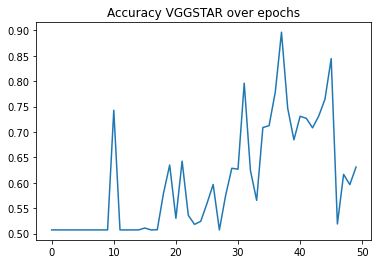

In [ ]:
if (DO=='TRAIN'):
  train(nets, loaders, optimizer, criterion, epochs=50, dev=dev,save_param=True)
else:
  state_dicts = torch.load('model.pth')
  model1.load_state_dict(state_dicts['vgg_a']) #questi state_dict vengono dalla funzione di training
  model2.load_state_dict(state_dicts['vgg_b'])
  model3.load_state_dict(state_dicts['vgg_star'])
  classifier.load_state_dict(state_dicts['classifier'])

  test(model1,classifier,test_loader_all)
  test(model2, classifier, test_loader_all)
  test(model3, classifier, test_loader_all)

  summed_state_dict = OrderedDict()

  for key in state_dicts['vgg_star']:
    if key.find('conv') >=0:
      print(key)
      summed_state_dict[key] = combo_fn(state_dicts['vgg_a'][key],state_dicts['vgg_b'][key])
    else:
      summed_state_dict[key] = state_dicts['vgg_star'][key]

  model3.load_state_dict(summed_state_dict)
  test(model3, classifier, test_loader_all)